<a href="https://colab.research.google.com/github/Yarrieta/Entregas_PNL/blob/Desafio4/6_bot_qa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Bot QA

### Datos
El objecto es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)

In [54]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [55]:
import re

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot # Use tensorflow.keras.preprocessing.text
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.models import Sequential # Use tensorflow.keras.models
from tensorflow.keras.layers import Activation, Dropout, Dense # Use tensorflow.keras.layers
from tensorflow.keras.layers import Flatten, LSTM, SimpleRNN # Use tensorflow.keras.layers
from tensorflow.keras.models import Model # Use tensorflow.keras.models
from tensorflow.keras.layers import Embedding # Use tensorflow.keras.layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer # Use tensorflow.keras.preprocessing.text
from tensorflow.keras.layers import Input # Use tensorflow.keras.layers
from tensorflow.keras.utils import plot_model

In [56]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [57]:
# dataset_file
import json

text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f) # la variable data será un diccionario



In [58]:
# Observar los campos disponibles en cada linea del dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [59]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30

def clean_text(txt):
    txt = txt.lower()
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)

    return txt

for line in data:
    for i in range(len(line['dialog'])-1):
        # vamos separando el texto en "preguntas" (chat_in)
        # y "respuestas" (chat_out)
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out

        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 6033


In [60]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you ', 'not bad and you  <eos>', '<sos> not bad and you ')

### 2 - Preprocesamiento
Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

In [61]:
# Definir el tamaño máximo del vocabulario
MAX_VOCAB_SIZE = 8000

In [87]:

# tokenizador de español
# A los filtros de símbolos del Tokenizer agregamos el "¿",
# sacamos los "<>" para que no afectar nuestros tokens
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_outputs))

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE)
# Se suma 1 para incluir el token de palabra desconocida

print("Palabras en el vocabulario:", num_words_output)

max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)

Palabras en el vocabulario: 1806
Palabras en el vocabulario: 1807
Sentencia de salida más larga: 10


In [88]:
# Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# - num_words --> the maximum number of words to keep, based on word frequency.
# - Only the most common num_words-1 words will be kept.
from tensorflow.keras.preprocessing.text import Tokenizer

# tokenizador de inglés
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)

Palabras en el vocabulario: 1799
Sentencia de entrada más larga: 9


In [89]:
# Por una cuestion de que no explote la RAM se limitará el tamaño de las sentencias de entrada
# a la mitad:
max_input_len = 16
max_out_len = 18

In [90]:
print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

Cantidad de rows del dataset: 6033
encoder_input_sequences shape: (6033, 16)
decoder_input_sequences shape: (6033, 18)


In [91]:
from tensorflow.keras.utils import to_categorical
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)
decoder_targets.shape

(6033, 18, 1807)

### 3 - Preparar los embeddings
Utilizar los embeddings de Glove o FastText para transformar los tokens de entrada en vectores

In [92]:
# Descargar los embeddings desde un google drive (es la forma más rápida)
# NOTA: No hay garantía de que estos links perduren, en caso de que no estén
# disponibles descargar de la página oficial como se explica en el siguiente bloque de código
import os
import gdown
if os.access('gloveembedding.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download'
    output = 'gloveembedding.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings gloveembedding.pkl ya están descargados")

Los embeddings gloveembedding.pkl ya están descargados


In [68]:
# En caso de que gdown de algún error de permisos intentar descargar los
# embeddings con curl:

#!curl -L -o 'gloveembedding.pkl' 'https://drive.google.com/u/0/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download&confirm=t'

In [93]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [94]:
# Por una cuestion de RAM se utilizarán los embeddings de Glove de dimension 300
#gloveembedding.pkl
model_embeddings = GloveEmbeddings()

In [95]:
# Crear la Embedding matrix de las secuencias
# en inglés

print('preparing embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

# word_index provieen del tokenizer

nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:

        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 38


In [96]:
# Dimensión de los embeddings de la secuencia en inglés
embedding_matrix.shape

(1799, 50)

### 4 - Entrenar el modelo
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilce como referencias los ejemplos vistos en clase.

In [73]:
max_input_len

16

In [74]:
max_out_len

18

In [97]:
num_words_output

1807

In [100]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense

n_units = 128
dropout_rate = 0.2

# define training encoder
encoder_inputs = Input(shape=(max_input_len,))

#encoder_embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

encoder_embedding_layer = Embedding(
          input_dim=nb_words,  # definido en el Tokenizador
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=max_input_len, # tamaño máximo de la secuencia de entrada
          weights=[embedding_matrix],  # matrix de embeddings
          trainable=False)      # marcar como layer no entrenable

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

#primera capa LSTM
encoder1 = LSTM(n_units,  return_sequences=True, return_state=True, dropout=dropout_rate)
encoder_outputs1, state_h1, state_c1 = encoder1(encoder_inputs_x)

# segunda capa LSTM
encoder2 = LSTM(n_units,  return_sequences=False, return_state=True, dropout=dropout_rate)
encoder_outputs, state_h, state_c = encoder2(encoder_outputs1)

encoder_states = [state_h, state_c]

# define training decoder
decoder_inputs = Input(shape=(max_out_len,))

decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=n_units, input_length=max_out_len)
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

#primera capa decoder LSTM
decoder_lstm1 = LSTM(n_units, return_sequences=True, return_state=True, dropout=dropout_rate)
decoder_outputs1, _, _ = decoder_lstm1(decoder_inputs_x, initial_state=encoder_states)

#segundo capa decoder LSTM
decoder_lstm2 = LSTM(n_units, return_sequences=True, return_state=True, dropout=dropout_rate)
decoder_outputs, _, _ = decoder_lstm2(decoder_outputs1)

# Dense
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16            │ (None, 16)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_10 (Embedding)  │ (None, 16, 50)         │         89,950 │ input_layer_16[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_17            │ (None, 18)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_20 (LSTM)            │ [(None, 16, 128),      │         91,648 │ embedding_10[0][0]     │
│                           │ (None, 128), (None,    │                │                        │
│                           │ 128)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_11 (Embedding)  │ (None, 18, 128)        │        231,296 │ input_layer_17[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_21 (LSTM)            │ [(None, 128), (None,   │        131,584 │ lstm_20[0][0]          │
│                           │ 128), (None, 128)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_22 (LSTM)            │ [(None, 18, 128),      │        131,584 │ embedding_11[0][0],    │
│                           │ (None, 128), (None,    │                │ lstm_21[0][1],         │
│                           │ 128)]                  │                │ lstm_21[0][2]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_23 (LSTM)            │ [(None, 18, 128),      │        131,584 │ lstm_22[0][0]          │
│                           │ (None, 128), (None,    │                │                        │
│                           │ 128)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 18, 1807)       │        233,103 │ lstm_23[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,040,749 (3.97 MB)

 Trainable params: 950,799 (3.63 MB)

 Non-trainable params: 89,950 (351.37 KB)

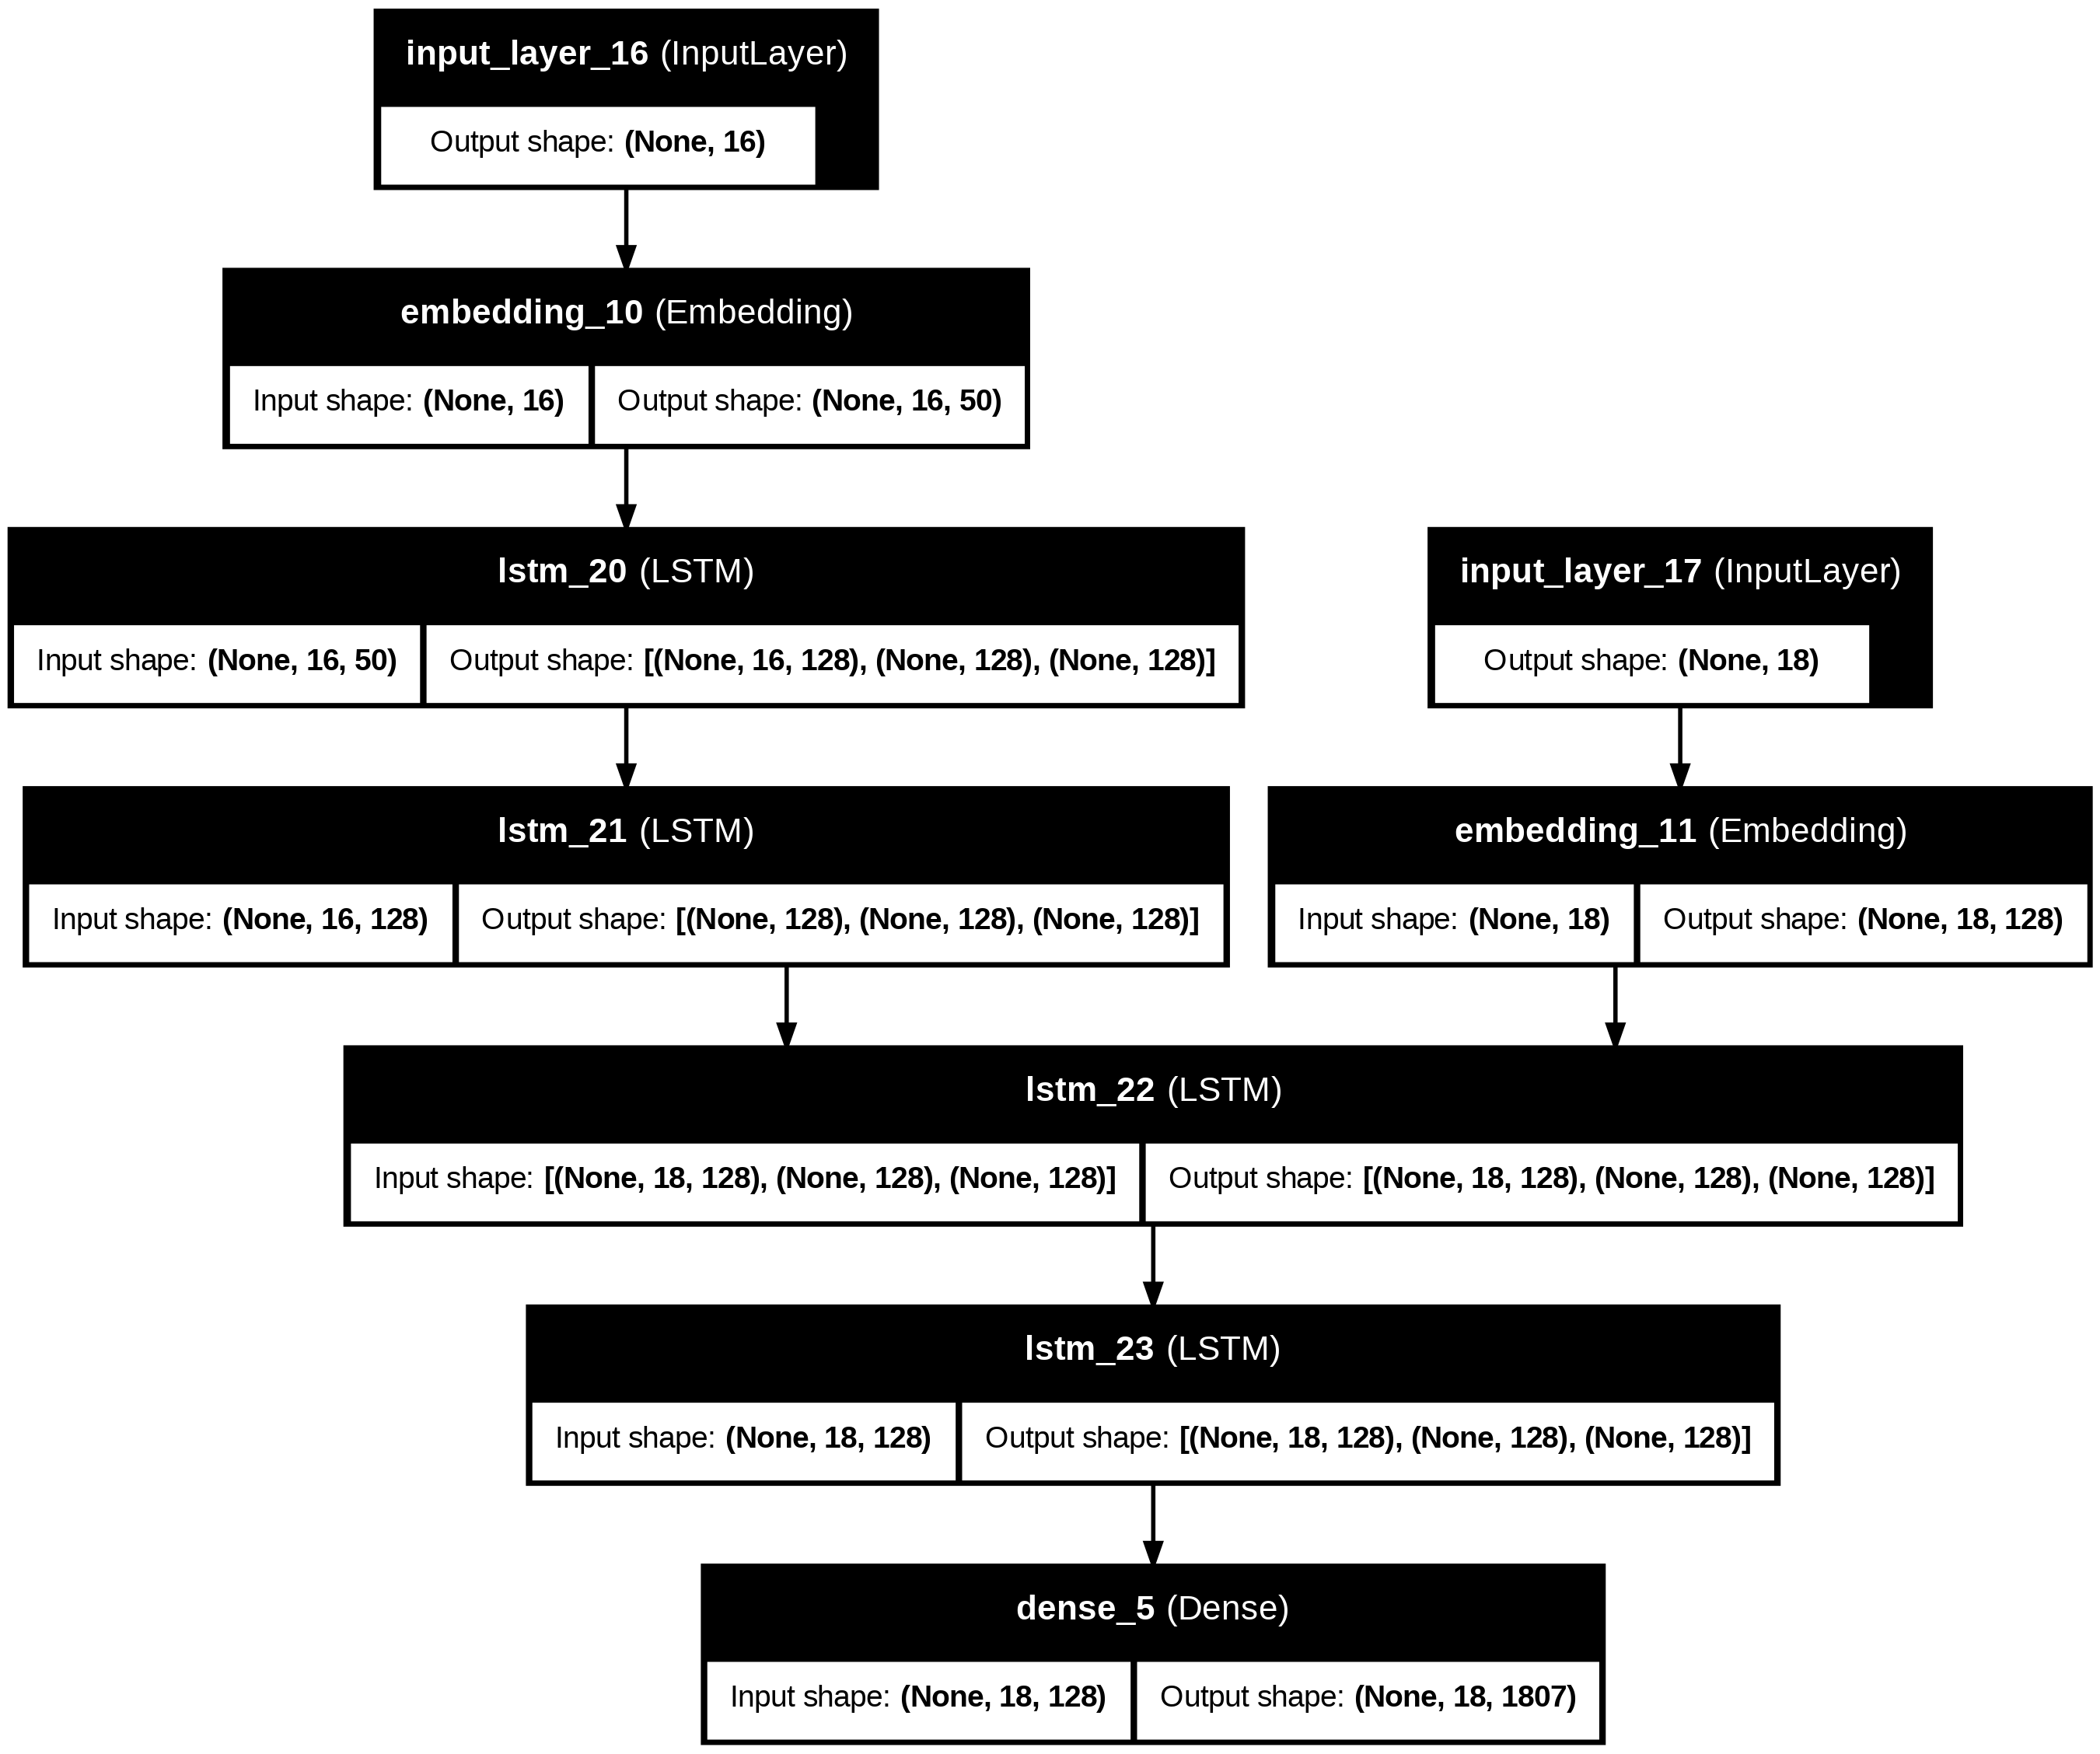

In [101]:
# Modelo completo (encoder+decoder) para poder entrenar
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

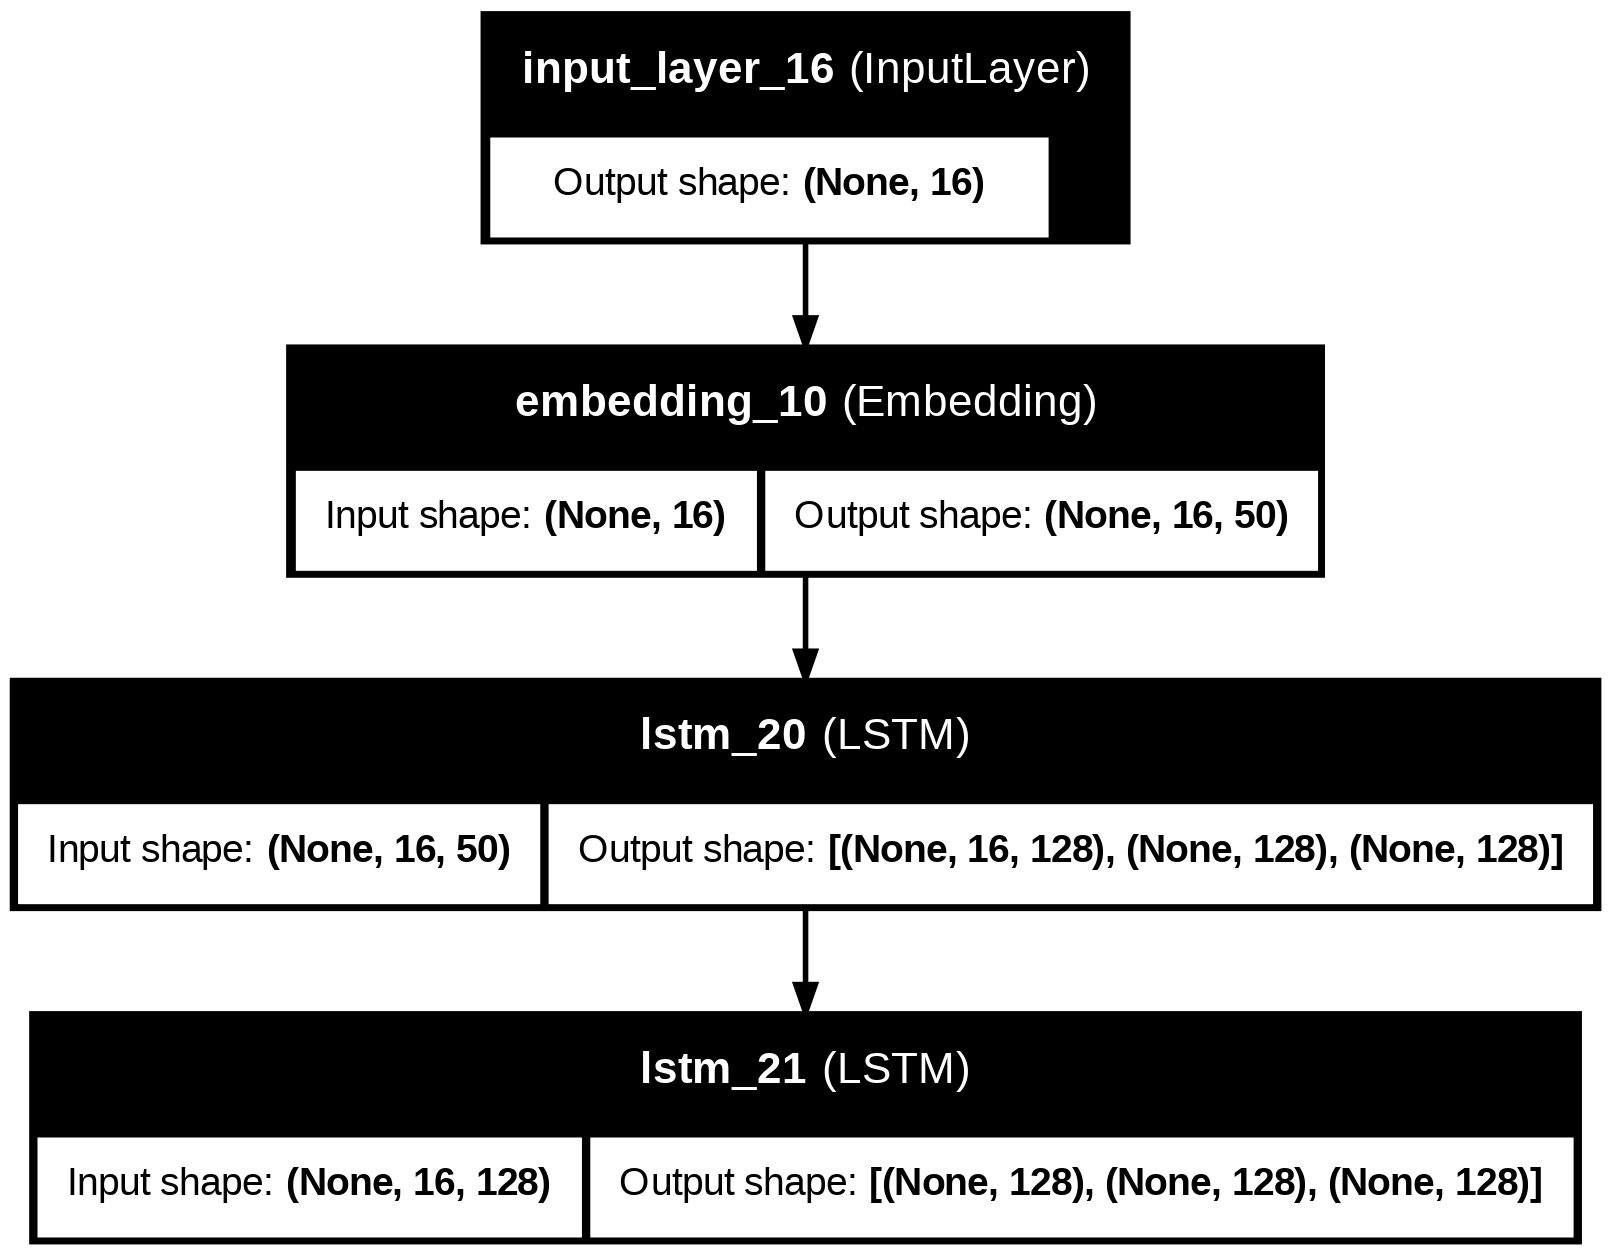

In [113]:
# Modelo solo encoder

# define inference encoder
encoder_model = Model(encoder_inputs, encoder_states)

plot_model(encoder_model, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

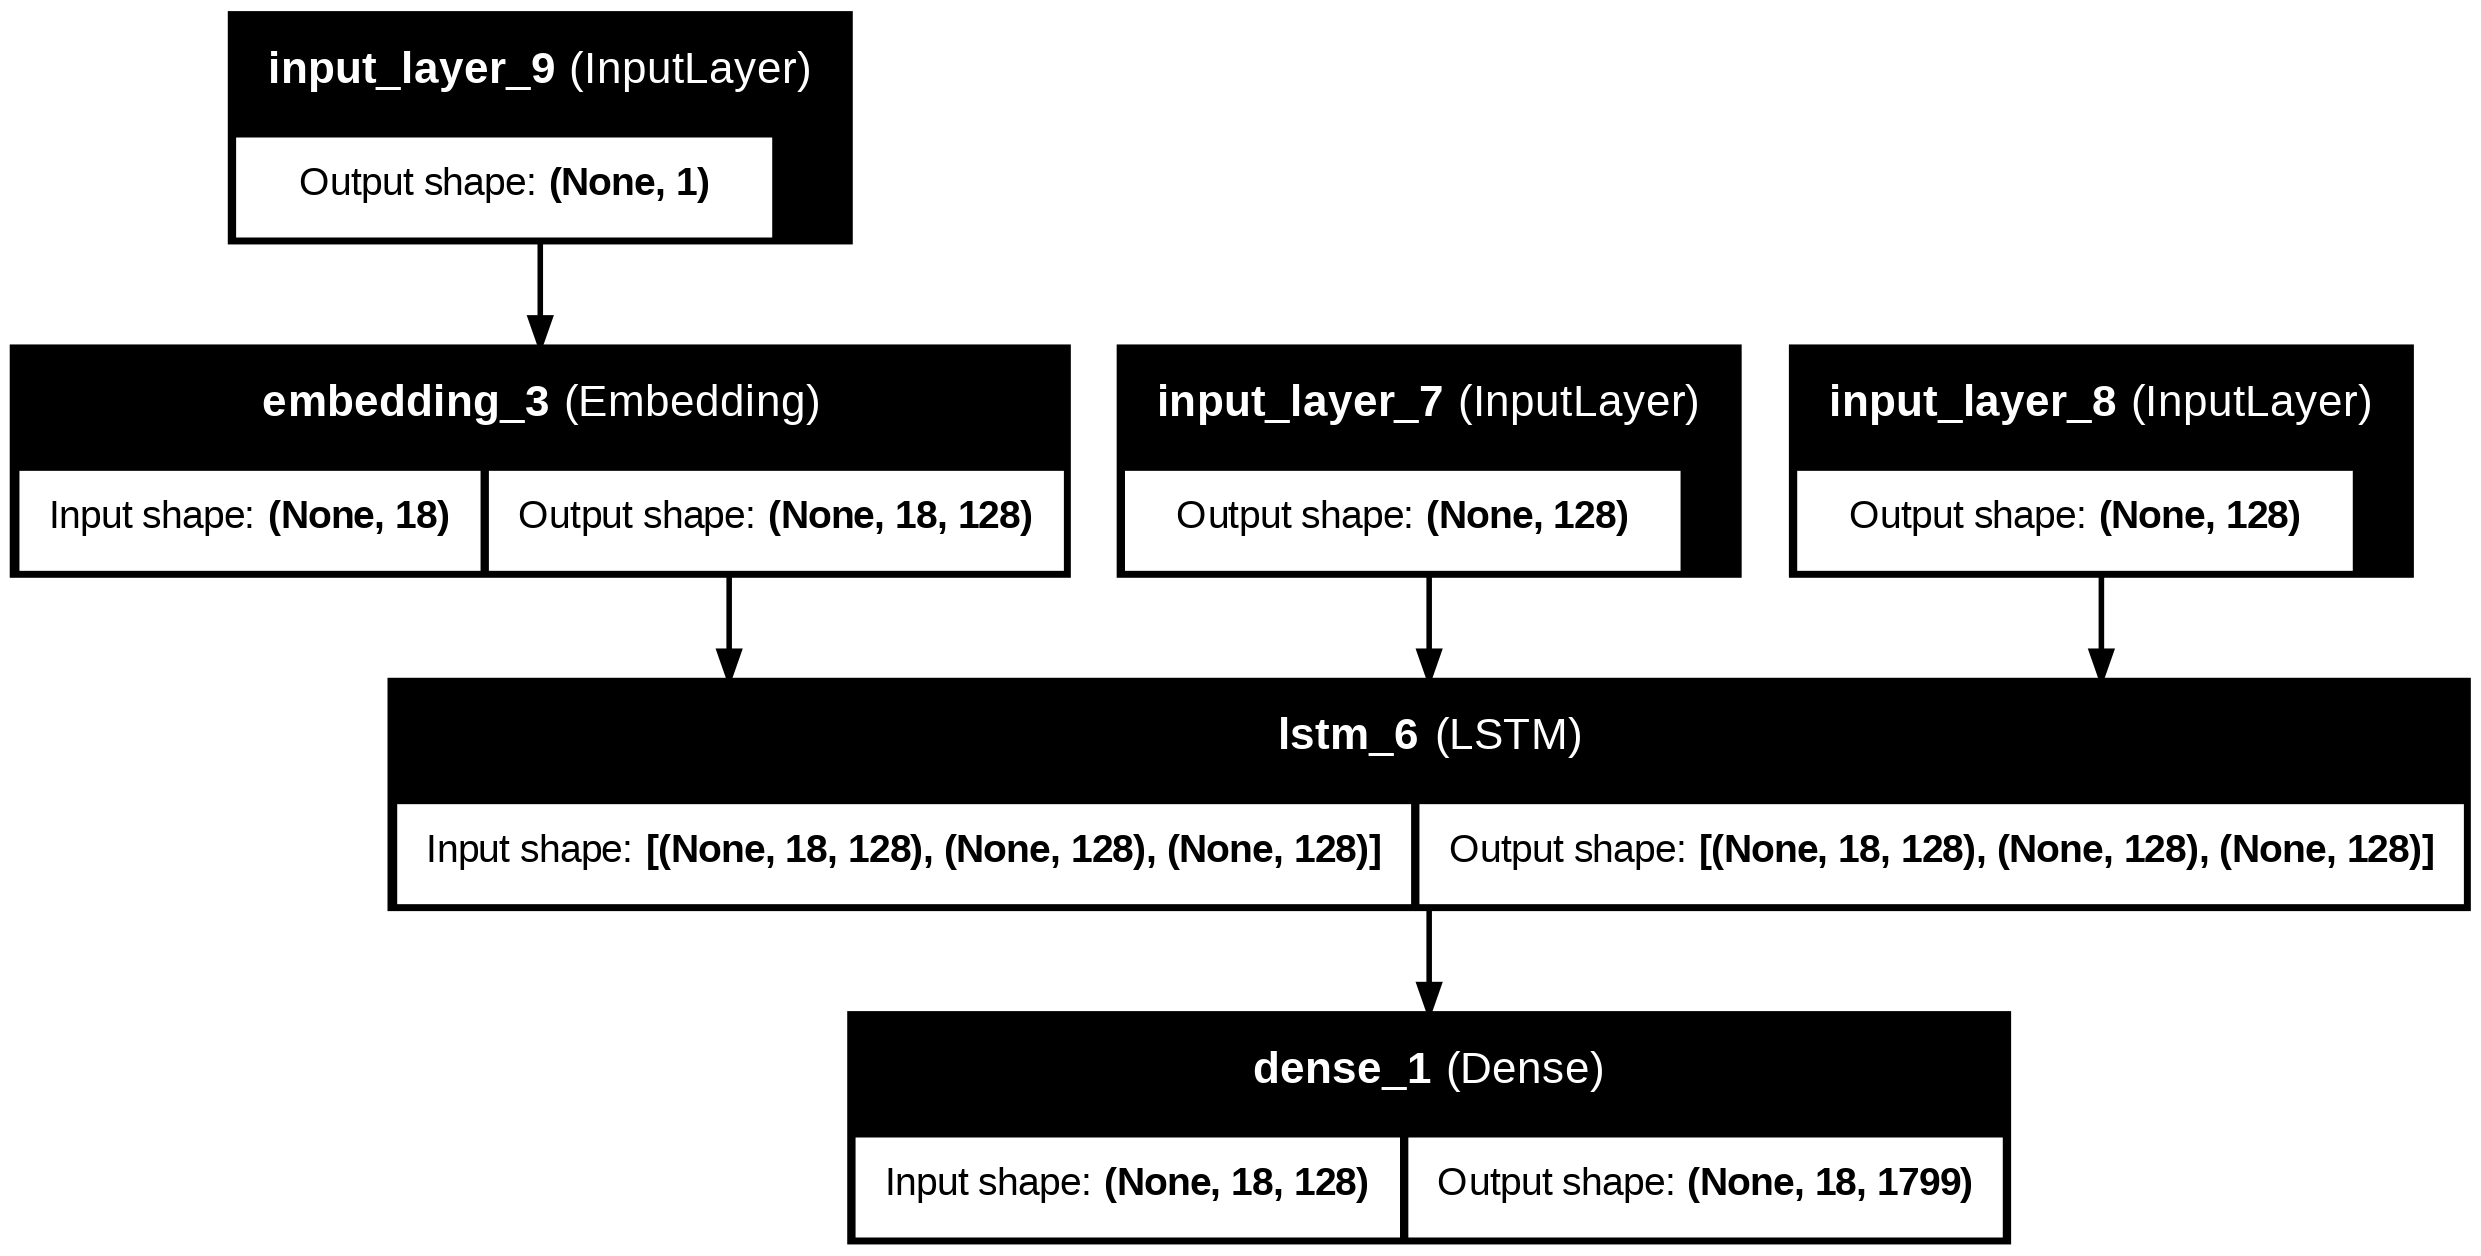

In [79]:
# Modelo solo decoder (para realizar inferencia)

# define inference decoder
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# En cada predicción habrá una sola palabra de entrada al decoder,
# que es la realimentación de la palabra anterior
# por lo que hay que modificar el input shape de la layer de Embedding
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, state_h, state_c = decoder_lstm1(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

plot_model(decoder_model, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)

In [103]:
# Assuming 'encoder_input_sequences' and 'decoder_input_sequences' are numpy arrays
encoder_input_sequences = encoder_input_sequences - 1
decoder_input_sequences = decoder_input_sequences - 1

In [104]:
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=15,
    validation_split=0.2)

Epoch 1/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 33s 219ms/step - accuracy: 0.7536 - loss: 1.3501 - val_accuracy: 0.7957 - val_loss: 1.2675
Epoch 2/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 30s 200ms/step - accuracy: 0.7850 - loss: 1.1972 - val_accuracy: 0.7932 - val_loss: 1.2334
Epoch 3/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 41s 199ms/step - accuracy: 0.7884 - loss: 1.1578 - val_accuracy: 0.8012 - val_loss: 1.2087
Epoch 4/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 32s 212ms/step - accuracy: 0.7975 - loss: 1.1067 - val_accuracy: 0.8063 - val_loss: 1.1628
Epoch 5/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 30s 197ms/step - accuracy: 0.8085 - loss: 1.0409 - val_accuracy: 0.8161 - val_loss: 1.1204
Epoch 6/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 43s 206ms/step - accuracy: 0.8247 - loss: 0.9784 - val_accuracy: 0.8188 - val_loss: 1.0875
Epoch 7/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 42s 212ms/step - accuracy: 0.8281 - loss: 0.9533 - val_accuracy: 0.8240 - val_loss: 1.0569
Epoch 8/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 39s 199ms/step - accuracy: 0.8353 - loss: 0

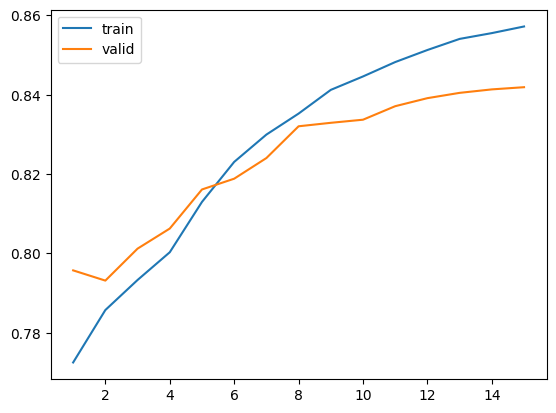

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Inferencia
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.

##### Encoder y decoder

In [106]:
# Armar los conversores de índice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [110]:
def translate_sentence(input_seq):
    # Se transforma la sequencia de entrada a los estados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder
    states_value = encoder_model.predict(input_seq)

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    # Se obtiene el índice que finaliza la inferencia
    eos = word2idx_outputs['<eos>']

    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar idx a palabra
        word = ''
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dada la última predicción
        states_value = [h, c]

        # Actualizar secuencia de entrada con la salida (re-alimentación)
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

In [108]:
input_test = "Do you read?"
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
translation = translate_sentence(encoder_sequence_test)
print('Response:', translation)

Input: Do you read?
Representacion en vector de tokens de ids [3, 2, 23]
Padding del vector: [[ 0  0  0  0  0  0  0  0  0  0  0  0  0  3  2 23]]
Input: Do you read?
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Response: looking apple apple back looking shows papaya papaya yup plants cookies offive ha ha yr nepali juli

In [109]:
input_test = "Do you have any pet?"
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
translation = translate_sentence(encoder_sequence_test)
print('Response:', translation)

Input: Do you have any pet?
Representacion en vector de tokens de ids [3, 2, 16, 31, 252]
Padding del vector: [[  0   0   0   0   0   0   0   0   0   0   0   3   2  16  31 252]]
Input: Do you have any pet?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Response: looking looking shows looking shows papaya kha went sport sp

In [111]:
input_test = "Where are you from?"
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
translation = translate_sentence(encoder_sequence_test)
print('Response:', translation)

Input: Where are you from?
Representacion en vector de tokens de ids [52, 7, 2, 39]
Padding del vector: [[ 0  0  0  0  0  0  0  0  0  0  0  0 52  7  2 39]]
Input: Where are you from?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Response: looking apple looking shows papaya papaya recently kha sport sport sport gay who happ

In [112]:
input_test = "What is your name?"
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
translation = translate_sentence(encoder_sequence_test)
print('Response:', translation)

Input: What is your name?
Representacion en vector de tokens de ids [4, 15, 21, 51]
Padding del vector: [[ 0  0  0  0  0  0  0  0  0  0  0  0  4 15 21 51]]
Input: What is your name?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Response: c c c c se se yup kha bijoy extra hair f9 lesbian fool baby watermelon bots violin


##### Encoder

In [115]:
input_test = "What is your name?"
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
states_value = encoder_model.predict(encoder_sequence_test)

# states_value contendrá los estados ocultos h y c
state_h, state_c = states_value

# Imprimir los estados ocultos
print("State_h:", state_h)
print("State_c:", state_c)

Input: What is your name?
Representacion en vector de tokens de ids [4, 15, 21, 51]
Padding del vector: [[ 0  0  0  0  0  0  0  0  0  0  0  0  4 15 21 51]]
Input: What is your name?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
State_h: [[-9.9938500e-01 -9.9617863e-01  9.9768341e-01 -9.9714941e-01
   9.9369061e-01 -9.9476242e-01  9.9656624e-01  9.9304962e-01
   9.9799305e-01  9.9661309e-01 -9.9800843e-01 -9.9909496e-01
   9.9708319e-01  9.9879414e-01 -9.9838024e-01 -9.9857354e-01
  -9.9634057e-01  9.9679565e-01 -9.9838847e-01 -9.9634671e-01
  -9.9403465e-01  9.9714661e-01  9.9827456e-01  9.9866843e-01
  -9.9742287e-01 -9.9838680e-01  9.8738110e-01  9.9755347e-01
   9.9614483e-01 -9.9692917e-01  9.9779046e-01 -9.9833012e-01
   9.9794549e-01 -6.5147597e-01 -9.9564773e-01  9.9837208e-01
  -7.6100540e-01 -9.9714249e-01  9.9678057e-01  9.9845994e-01
   9.9354422e-01  9.9626833e-01 -6.8368190e-03 -9.9540001e-01
  -9.9803144e-01  9.9554133e-01  9.9752504e-01  9.9632573e-01
  -9.9663121e-01 -9.9898309

##### Dencoder

In [128]:
def translate_sentence(input_seq):
    # Se transforma la sequencia de entrada a los estados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder
    #states_value = encoder_model.predict(input_seq)


    input_test = "What is your name?"
    integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
    encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
    states_value = encoder_model.predict(encoder_sequence_test)

    # states_value contendrá los estados ocultos h y c
    state_h, state_c = states_value

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    # Se obtiene el índice que finaliza la inferencia
    eos = word2idx_outputs['<eos>']

    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        #output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        output_tokens, state_h, state_c = decoder_model.predict([target_seq]+ states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar idx a palabra
        word = ''
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dada la última predicción
        states_value = [state_h, state_c]

        # Actualizar secuencia de entrada con la salida (re-alimentación)
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

In [129]:
input_test = "What is your name?"
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
translation = translate_sentence(encoder_sequence_test)
print('Response:', translation)

Input: What is your name?
Representacion en vector de tokens de ids [4, 15, 21, 51]
Padding del vector: [[ 0  0  0  0  0  0  0  0  0  0  0  0  4 15 21 51]]
Input: What is your name?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Response: are living lot favorite living living living living living living living living living

En general se observa un buen desempeño del modelo propuesto, el cual tiene la arquitectura:

* Para el encoder una capa de embedding y dos capas LSTM.

* Para el decoder una capa de embedding, dos capas LSTM y una densa.

Se realizó inferencia con el modelo encoder-decoder. En la cual se observa que en cada una de las preguntas realizadas, el desempeño del modelo al generar las secuencias para la respuesta no sigue el contexto de la pregunta.

También se realizó una inferencia para una pregunta en la cual se generó la inferencia con el modelo sólo de encoder. Luego se tomó en cuenta los states_value generados por el encoder, para que sean usados por el modelo de decoder. El resultado tampoco tiene que ver con el contexto de la secuencia que se usó como entrada.